In [ ]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
import math
print(torch.cuda.is_available())

%matplotlib inline

False


# Prepare Dataset

In [ ]:
def prepare_torch_default_image(batch_size = 128):
  train_dataset = torchvision.datasets.LFWPeople(root=".", download = True, split = 'train')
  test_dataset = torchvision.datasets.LFWPeople(root=".", download = True, split = 'test')
  combine_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
  dataloader = torch.utils.data.DataLoader(combine_dataset, batch_size, shuffle=True)
  return combine_dataset, dataloader

dataset, dataloader = prepare_torch_default_image()


Files already downloaded and verified
Files already downloaded and verified


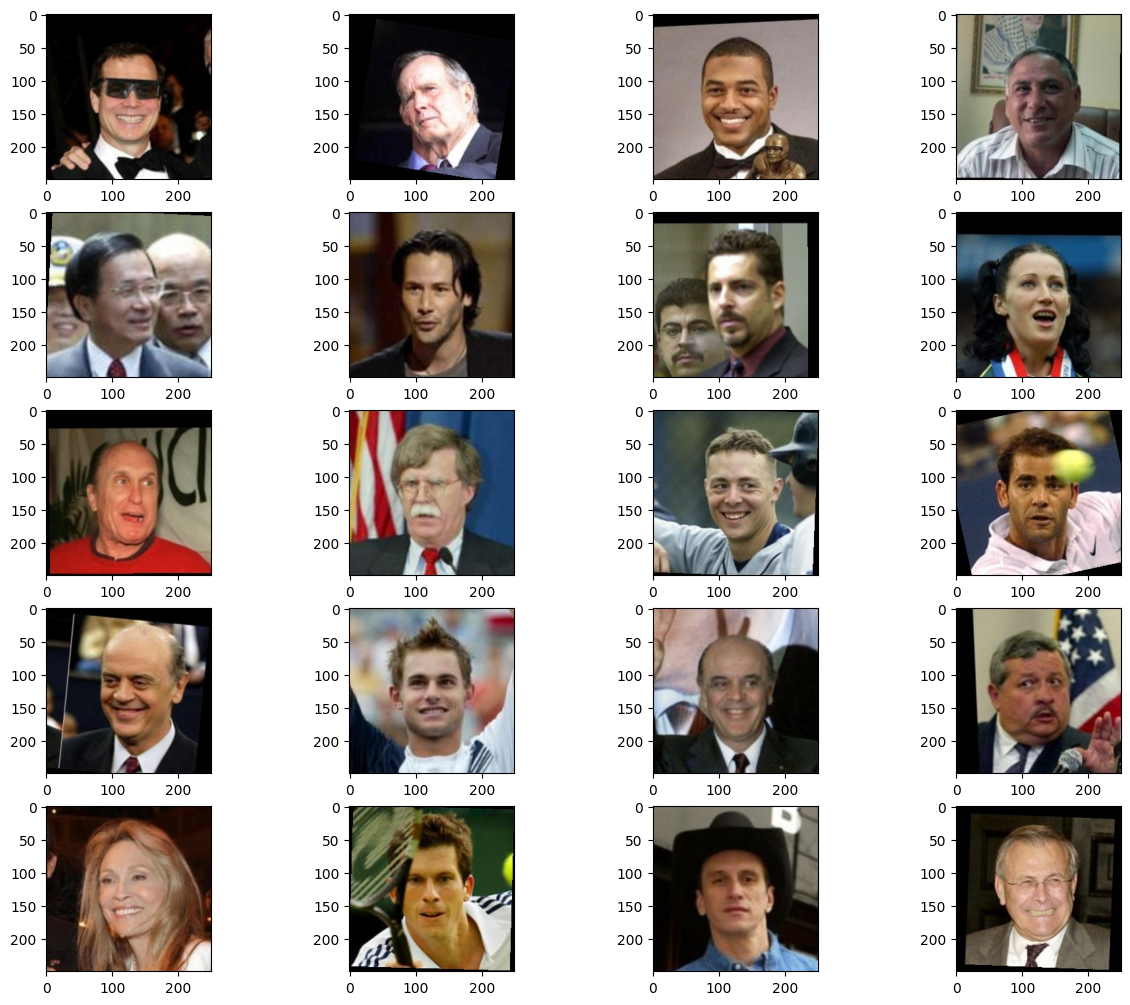

In [ ]:
def show_random_image(dataset, pic_amount = 20, column_amt = 4):
    plt.figure(figsize=(15,15))
    for i in range(pic_amount):
        randomIdx = random.randint(0, len(dataset) - 1)
        plt.subplot(int(pic_amount/column_amt) + 1, column_amt, i + 1)
        plt.imshow(dataset[randomIdx][0])

show_random_image(dataset)

In [ ]:
def print_data_info(dataset):
  print(f"Dataset size: {len(dataset)}")
  #verify whether all the dataset size is the same
  first_image_size = dataset[0][0].size
  print(f"First image size : {first_image_size}")
  all_same_size = True
  for i in range(len(dataset)):
    if(dataset[i][0].size != first_image_size):
      all_same_size = False
      break
  print(f"all same size: {all_same_size}")
print_data_info(dataset)

Dataset size: 13233
First image size : (250, 250)


# Create Diffusion: Forward Process

### Noise Scheduler

- To simplify things, noise scheduler will be fixed just like in [DDPM Paper](https://arxiv.org/pdf/2006.11239.pdf) for fixed forward and backward process variance.
- As the paper mentioned, since all the variables are fixed, no model needed, furthermore closed form formula can be derived for adding noise to a specific timestep (X_t) from original image (X_0)
- The scheduler for now also will just implement linear for simplicity

- For the value of Posterior variance, follow the second experiment value mentioned in DDPM
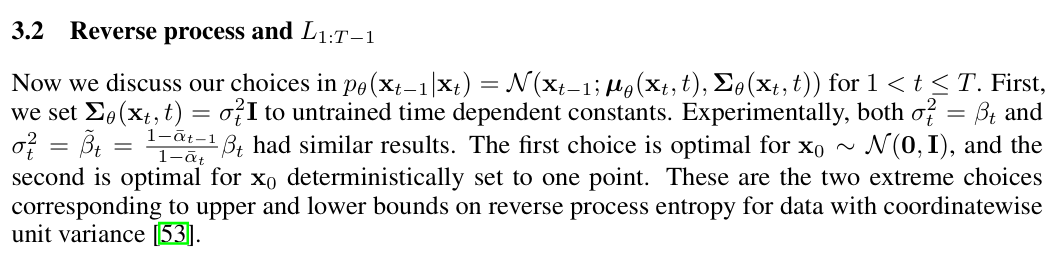

In [ ]:
class LinearNoiseScheduler():
  def __init__(self, total_timestep=300, beta_start=0.0001, beta_end=0.02): #beta following original DDPM paper, T is cut from 1000 to 300
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.total_timestep = total_timestep

  def generate_linspace(self)->torch.Tensor:
    return torch.linspace(self.beta_start, self.beta_end, self.total_timestep)

  def get_beta(self)->torch.Tensor:
    return self.generate_linspace()

  def get_alpha_cumprod(self)->torch.Tensor:
    linspace = self.generate_linspace()

    #alpha_t is 1 - beta_t
    alpha_linspace = 1.0 - linspace

    #get cumprod that will be used for closed form
    alpha_cumprod = torch.cumprod(alpha_linspace, dim=0)

    return alpha_cumprod

  def slide_right_pad_left(self, input: torch.Tensor, pad_slide_amount:int = 1, pad_value:float = 1.0):
    return torch.nn.functional.pad(input[:-pad_slide_amount], (pad_slide_amount, 0), value=pad_value)

  def get_sqrt_alpha_cumprod(self)->torch.Tensor:
    alpha_cumprod = self.get_alpha_cumprod()
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
    return sqrt_alpha_cumprod

  def get_sqrt_oneminus_alpha_cumprod(self)->torch.Tensor:
    alpha_cumprod = self.get_alpha_cumprod()
    one_minus_alpha_cumprod = 1. - alpha_cumprod
    one_minus_sqrt_alpha_cumprod = torch.sqrt(one_minus_alpha_cumprod)
    return one_minus_sqrt_alpha_cumprod

  def get_posterior_variances(self)->torch.Tensor:
    beta = self.get_beta()
    alpha_cumprod = self.get_alpha_cumprod()
    prev_alpha_cumprod = self.slide_right_pad_left(alpha_cumprod, 1, 1.0)
    return beta * (1. - prev_alpha_cumprod) / (1. - alpha_cumprod)

  def get_sqrt_one_per_alphas(self)->torch.Tensor:
    alpha = 1.0 - self.generate_linspace()
    return torch.sqrt(1.0 / alpha)

  @staticmethod
  def get_element_by_index(cumprod:torch.Tensor, t: torch.Tensor, picture_shape):
    """
    Helper function
    Returns a specific index t of a passed list of values cumprod
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = cumprod.gather(-1, t.cpu()) #from list of cumprod, get the specific at timestep t
    return out.reshape(batch_size, *((1,) * (len(picture_shape) - 1))).to(t.device) #return the result following the batchsize

In [ ]:
def forward_process(orig_picture_tensor: torch.Tensor, noise_scheduler: LinearNoiseScheduler, current_timestep:torch.Tensor, device = "cpu"):
  noise = torch.randn_like(orig_picture_tensor) #normal distribution between 0 and 1
  sqrt_alpha_cumprod_t = noise_scheduler.get_element_by_index(
      noise_scheduler.get_sqrt_alpha_cumprod(),
      current_timestep,
      orig_picture_tensor.shape
  )
  sqrt_oneminus_alpha_cumprod_t = noise_scheduler.get_element_by_index(
      noise_scheduler.get_sqrt_oneminus_alpha_cumprod(),
      current_timestep,
      orig_picture_tensor.shape
  )
  #picture at timestep t, with closed form formula (reparameterization theory)
  # picture_t = orig_picture_tensor * sqrt_alpha_cumprod_t + \
  #           sqrt_oneminus_alpha_cumprod_t * noise
  picture_t = orig_picture_tensor.to(device) * sqrt_alpha_cumprod_t.to(device) + \
             sqrt_oneminus_alpha_cumprod_t.to(device) * noise.to(device)
  return picture_t, noise.to(device)

### Data Loader and Testing
Reference notebook: [Notebook](https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=uuckjpW_k1LN)

In [ ]:
# Load Picture
def load_and_transform_data(image_size = 64, batch_size = 128): #batchsize follow CIFAR batch size of original DDPM paper
  "Load, normalize, augment picture data"
  transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize((image_size, image_size)),
      torchvision.transforms.RandomHorizontalFlip(), #following the DDPM original Paper
      torchvision.transforms.ToTensor(), # Scales data into [0,1]
      torchvision.transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
  ])

  train = torchvision.datasets.LFWPeople(root=".", download=True, transform=transforms)

  test = torchvision.datasets.LFWPeople(root=".", download=True, transform=transforms, split='test')

  combined_data = torch.utils.data.ConcatDataset([train, test])
  data_loader = torch.utils.data.DataLoader(combined_data, batch_size=batch_size, shuffle=True)
  return combined_data, data_loader

def show_tensor_image(image):
    reverse_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda t: (t + 1) / 2),
        torchvision.transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        torchvision.transforms.Lambda(lambda t: t * 255.),
        torchvision.transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        torchvision.transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

combined_data, data_loader = load_and_transform_data()

Files already downloaded and verified
Files already downloaded and verified


0
30
60


<ipython-input-7-7a584bfee590>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


90
120
150
180
210
240
270


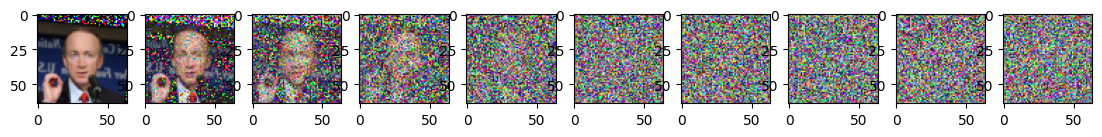

In [ ]:
# Simulate forward diffusion
def simulate_forward_diffusion(dataloader, total_timestep = 300):
  image = next(iter(dataloader))[0]

  plt.figure(figsize=(15,15))
  plt.axis('off')
  num_images = 10
  stepsize = int(total_timestep/num_images)
  linear_scheduler = LinearNoiseScheduler(total_timestep = total_timestep)

  for idx in range(0, total_timestep, stepsize):
      print(idx)
      t = torch.Tensor([idx]).type(torch.int64)
      plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
      img, noise = forward_process(image, linear_scheduler, t)
      show_tensor_image(img)

simulate_forward_diffusion(data_loader)

## Backward Process

### Time embedding
Time embedding will follow that of Transformers positional embedding, due to U-Net for different timestep will be the same
- Why Sinusoidal timestep encoding work well: [Reading](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)

In [ ]:
class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.dimension = dimension

    def forward(self, time):
        device = time.device
        half_dimension = self.dimension // 2
        embeddings = math.log(10000) / (half_dimension - 1)
        embeddings = torch.exp(torch.arange(half_dimension, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### U-Net

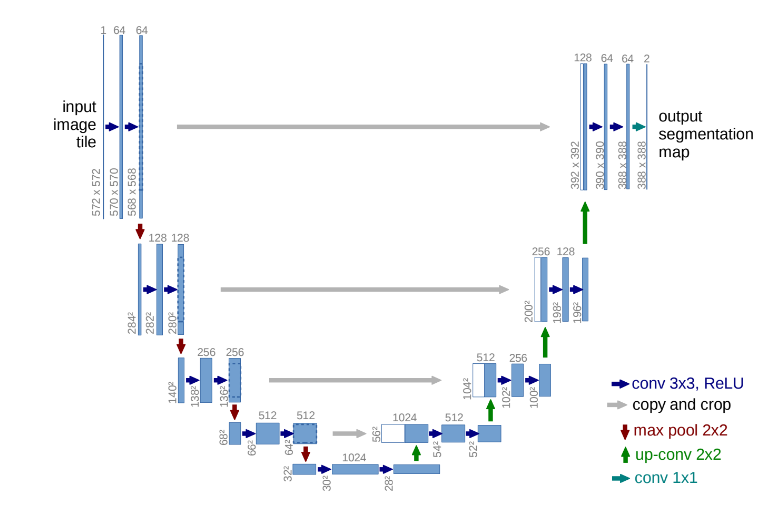

The above picture is UNet Architecture, although only the miniaturized is made for this project.

For the time embedding, it is usually inputted into a linear layer (MLP) for the model to incorporate time dynamics into stronger information (not linear, and learn temporal dynamics of denoising)

We are implementing the UNet Block (2x convolution in each row, and the final transformation (downsample or upsample))

In [ ]:
class UNetBlock(torch.nn.Module):
  def __init__(self, in_channel, out_channel, time_embedding_dim, downsample = True):
    super().__init__()

    self.time_linear =  torch.nn.Sequential(
        torch.nn.Linear(time_embedding_dim, out_channel),
        torch.nn.ReLU()
    )


    #use padding = 1 in 3x3 convolutions to ensure same
    #first convolution is without the time_mlp result
    # in channel is times two for upsample due to concatenation of residual connection
    if downsample:
        self.first_convolution = torch.nn.Sequential(
            torch.nn.Conv2d(in_channel, out_channel, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channel),
        )
        self.second_convolution = torch.nn.Sequential(
            torch.nn.Conv2d(out_channel, out_channel, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channel),
            torch.nn.Conv2d(out_channel, out_channel, 4, 2, 1),
        )
    else:
        self.first_convolution = torch.nn.Sequential(
            torch.nn.Conv2d(2*in_channel, out_channel, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channel),
        )
        self.second_convolution = torch.nn.Sequential(
            torch.nn.Conv2d(out_channel, out_channel, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channel),
            torch.nn.ConvTranspose2d(out_channel, out_channel, 4, 2, 1)
        )

  def forward(self, x, t):
        # First Conv
        h = self.first_convolution(x)
        # Time embedding
        time_emb = self.time_linear(t)
        # Extend last 2 dimensions.
        # Convert the shape of time_embedding from [t] to [channel (t), h w]
        # batch size is in the front
        # Use None to add new axis
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # element wise addition time to spatial result
        h = h + time_emb
        # Second Conv
        return self.second_convolution(h)

In [ ]:
class MiniUNet(torch.nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_input_channels = 3
        down_up_channels = (64, 128, 256, 512, 1024) #make sure to be ascending
        output_channels = 3
        time_embedding_dimension = 32

        # Time embedding
        self.time_mlp = torch.nn.Sequential(
                SinusoidalPositionEmbeddings(time_embedding_dimension),
                torch.nn.Linear(time_embedding_dimension, time_embedding_dimension),
                torch.nn.ReLU()
            )

        # Initial projection (first convolution to only change channel)
        self.conv0 = torch.nn.Conv2d(image_input_channels, down_up_channels[0], 3, padding=1)

        # Downsample
        self.downs = torch.nn.ModuleList([UNetBlock(down_up_channels[i], down_up_channels[i+1], \
                                    time_embedding_dimension, downsample = True) \
                    for i in range(len(down_up_channels)-1)])

        #No Flat convolution implemented

        # Upsample
        self.ups = torch.nn.ModuleList([UNetBlock(down_up_channels[i], down_up_channels[i-1], \
                                        time_embedding_dimension, downsample = False) \
                    for i in range(len(down_up_channels)-1, 0, -1)])

        # Final layer end with 1x1 convolution
        self.output = torch.nn.Conv2d(down_up_channels[0], output_channels, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [ ]:
#check model correctness with init
model = MiniUNet()
print("Params sum: ", sum(p.numel() for p in model.parameters()))
model

Params sum:  62438883


MiniUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): UNetBlock(
      (time_linear): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
      )
      (first_convolution): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (second_convolution): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
    )
    (1): UNetBlock(
      (t

# Loss
See Math derivation from Outlier's Video: [link](https://www.youtube.com/watch?v=HoKDTa5jHvg)

We just need to find the difference (L1 Loss) of noise and actual noise. This whole derivation is possible because we set variance of model as fixed

In [21]:
def get_loss(model, x_0, noise_scheduler, t, device):
    x_noisy, noise = forward_process(x_0, noise_scheduler, t, device)
    noise_pred = model(x_noisy, t)
    return torch.nn.functional.l1_loss(noise, noise_pred)

# Sampling

Follow the algorithm derived from the paper to returned the denoised image.

Posterior variances uses the previously mentioned second experiment value. (Fixed and not predicted using a model)

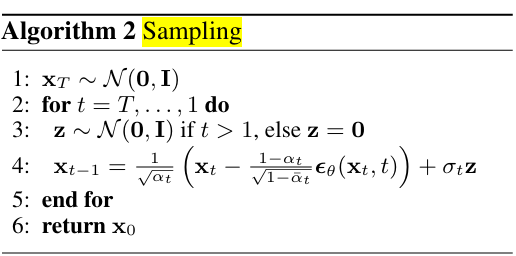

In [27]:
@torch.no_grad()
def sample_denoised_image_per_timestep(x: torch.Tensor, t:torch.Tensor, model: MiniUNet, noise_scheduler = LinearNoiseScheduler()):
    """
    Returns the denoised sampled image (from paper algortihm 2) in one iteration
    set torch.no_grad to prevent pytorch from caching previous image input for gradient
    No Learning will be done inside this function
    """
    beta_t = noise_scheduler.get_element_by_index(
        noise_scheduler.get_beta(),
        t,
        x.shape)
    sqrt_one_minus_alpha_cumprod_t = noise_scheduler.get_element_by_index(
        noise_scheduler.get_sqrt_oneminus_alpha_cumprod(),
        t,
        x.shape
    )
    sqrt_one_per_alpha_t = noise_scheduler.get_element_by_index(
        noise_scheduler.get_sqrt_one_per_alphas(),
        t,
        x.shape
    )

    # Remember that beta = 1 - alpha
    model_mean = sqrt_one_per_alpha_t * (
        x - beta_t * model(x, t) / sqrt_one_minus_alpha_cumprod_t
    )
    posterior_variance_t = noise_scheduler.get_element_by_index(
        noise_scheduler.get_posterior_variances(),
        t,
        x.shape)

    if t == 0:
        # the initial timestep doesn't have to add posterior variance noise
        # note that the paper t starts from 1, I start from 0
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_and_plot_image(image_size: int, device, model: MiniUNet, noise_scheduler: LinearNoiseScheduler):
    # Sample noise
    img = torch.randn((1, 3, image_size, image_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    total_timestep = noise_scheduler.total_timestep
    stepsize = int(total_timestep/num_images)
    for t_int in range(0,total_timestep)[::-1]:
        t = torch.tensor([t_int], device=device, dtype=torch.long)
        img = sample_denoised_image_per_timestep(img, t, model, noise_scheduler)
        # maintain range of denoised image in normalized range
        img = torch.clamp(img, -1.0, 1.0)
        if t_int % stepsize == 0:
            plt.subplot(1, num_images, int(t_int/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

# Training

A few notes:
- Optimizer uses Adam with lr 2 x 10-4, following the paper for smaller image
- Batch size follow original ddpm paper: 128
- image size smaller due to limitation for training instance: 64
- Loss is using randomized timestep implementation as the original DDPM Paper
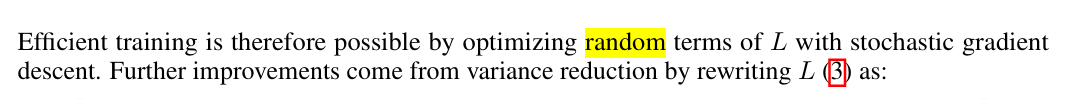

Files already downloaded and verified
Files already downloaded and verified
Epoch 0 | step 000 Loss: 0.808682918548584 


<ipython-input-27-7a95ea6e95b3>:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(t_int/stepsize)+1)


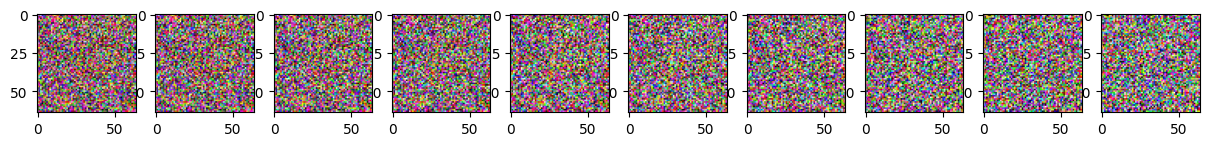

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"


model = MiniUNet()
model.to(device)

total_timestep = 300

linear_scheduler = LinearNoiseScheduler(total_timestep = total_timestep)

optimizer = Adam(model.parameters(), lr=0.001) #make it larger to 0.001
epochs = 100
image_size = 64
batch_size = 128

_, dataloader = load_and_transform_data(image_size, batch_size)

for epoch in range(epochs):
    for step, image_batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, total_timestep, (batch_size,), device=device).long()
      loss = get_loss(model, image_batch[0], linear_scheduler, t, device)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_and_plot_image(image_size, device, model, linear_scheduler)